In [2]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from navec import Navec
from slovnet.model.emb import NavecEmbedding
from tg.projects.retell.retell_utils.metrics import get_cosine_sim, get_jaccard_index,plot_bar_jac_cos_metric
from pathlib import Path
from tg.projects.retell.retell_utils.corpora_sugar import CorpusSugar
from tg.grammar_ru.corpus import CorpusReader

Подумать над тем, делать ли словарь для каждой главы отдельно, или для всей книги сразу.
Логично, если для отдельной главы, то сохранится контекст главы. В разных главах персонаж может находиться в различных местах (Джон Сноу у стены, Джон Сноу в городе), и для пересказа контекст конкретной главы - важен.
Но попробовать для всей книги ничего не мешает. Ведь можно дообучать Word2Vec идя по главам. Контекст в модели наверняка будет изменяться.

In [3]:
retell_corpus = CorpusReader(Path("./featurized_corpuses/All retell.featurized.retell.corpus.zip"))
text_corpus = CorpusReader(Path("./featurized_corpuses/books.featurized.zip"))
martin_mapping = retell_corpus.read_mapping_data()

FileNotFoundError: [Errno 2] No such file or directory: 'featurized_corpuses\\All retell.featurized.retell.corpus.zip'

In [ ]:
corpus_sugar = CorpusSugar(text_corpus, retell_corpus)
books, retell_books, summar_books = corpus_sugar.get_books_retell_info_by_author('Мартин')

In [ ]:
model_path = Path("./navec_hudlit_v1_12B_500K_300d_100q.tar")
navec = Navec.load(model_path)
embeder = NavecEmbedding(navec)

/home/mixailkys/anaconda3/envs/grammar_ru/lib/python3.8/site-packages/slovnet/model/emb.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402316912/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  torch.from_numpy(navec.pq.indexes),


In [ ]:
def get_sentences(chapter):
    chptr = text_corpus.get_bundles([chapter]).single()
    chapter_id = chptr.src
    sentences_id = np.array(chapter_id['sentence_id'].unique())
    sentences = [chapter_id['word'].values[chapter_id['sentence_id'] == sentence_id]
                 for sentence_id in sentences_id]
    return sentences

In [ ]:
ban_words = {'-', ',', '.', '!', '—'}
retell_detail = 5
for book in books[:1]:
    extract_retell = []
    for chapter in book.index:
        sentences = get_sentences(chapter)
        vec_sum_sentences = []
        for sentence in sentences:
            tokens = [word_ for word in sentence
                      if word not in ban_words and (word_ := word.lower()) in navec.vocab]
            sentence_vector_sum = sum([embeder(torch.tensor(navec.vocab[token])) for token in tokens])
            vec_sum_sentences.append(sentence_vector_sum / len(tokens) if len(tokens) > 0 else torch.zeros(300))
        importances = []
        cos = torch.nn.CosineSimilarity(dim=0)
        for i in range(len(vec_sum_sentences)):
            importance = 0
            for j in range(i,len(vec_sum_sentences)):
                importance += cos(vec_sum_sentences[i],vec_sum_sentences[j])
            importances.append(importance)
        sorted_index_array = np.argsort(importances)[::-1]
        top_sentences = [" ".join(sentences[id]) for id in sorted_index_array[:retell_detail]]
        extract_retell.append("\n".join(top_sentences))

In [ ]:
true_retell = []
for book in retell_books[:1]:
    for chapter in book.index:
        chptr = retell_corpus.get_bundles([chapter]).single().src
        sentences_id = np.array(chptr['sentence_id'].unique())
        sentences = [chptr['word'][chptr['sentence_id'] == sentence_id] for sentence_id in sentences_id]
        true_retell.append("\n".join(" ".join(sentence.values) for sentence in sentences[:retell_detail]))

In [ ]:
jaccard_sim = np.array([jaccard_text(extract_retell[i],true_retell[i]) for i in range(len(true_retell))])
cos_sim = np.array([get_cosine_sim(extract_retell[i],true_retell[i]) for i in range(len(true_retell))])

In [ ]:
def bar_jac_cos_metric(jac, cos_):
    fig, axis = plt.subplots(2, 1)
    axis[0].bar(range(len(jac)), jac)
    axis[0].set_title('Индекс Жаккара')
    axis[1].bar(range(len(cos_)), cos_)
    axis[1].set_title('Косинусное расстояние')
    plt.subplots_adjust(left=0, right=1, wspace=0, hspace=0.5)


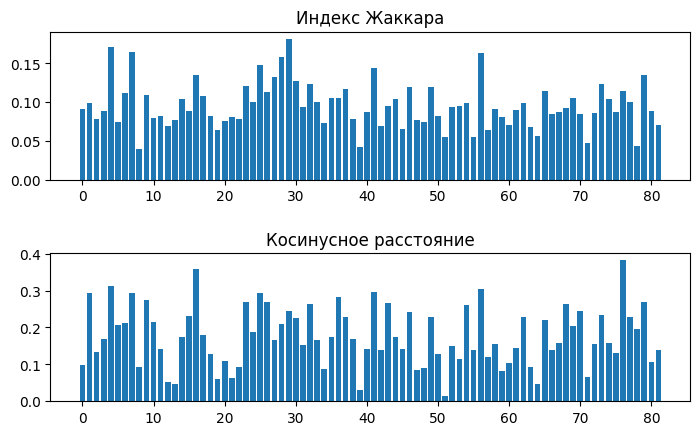

In [ ]:
bar_jac_cos_metric(jaccard_sim,cos_sim)

In [ ]:
np.sort(cos_sim)[::-1][:5]

array([0.38138504, 0.35781411, 0.31106654, 0.30382181, 0.29492349])

In [ ]:
np.sort(jaccard_sim)[::-1][:5]

array([0.18181818, 0.17171717, 0.16483516, 0.16304348, 0.15853659])

In [ ]:
def display_arg_max_min_text(retell_,true_text,sim_metric):
    argmax = sim_metric.argmax()
    argmin = sim_metric.argmin()
    display("Текст с наибольшим значением метрики")
    display(retell_[argmax])
    display(true_text[argmax])
    display("Текст с наименьшим значением метрики")
    display(retell_[argmin])
    display(true_text[argmin])

In [ ]:
display("Коэфициент Жаккара")
display_arg_max_min_text(extract_retell,true_retell,jaccard_sim)

'Коэфициент Жаккара'

'Текст с наибольшим значением метрики'

'Но Роберта он найти не успел , потому что лорд Эддард и ваш дед подошли к городу и взяли приступом его стены .\n— Люди Безумного Короля охотились за Робертом , стараясь схватить его до того , как он соединится с вашим отцом , — рассказывал он , когда они въезжали в ворота .\nЭту битву потом назвали Колокольной , и Роберт всегда говорил , что ее выиграл ваш отец , а не он .\n— Как у вас с едой ? — спросил его Том .\nКаменная Септа была самым большим городом , который Арья видела после Королевской Гавани , и Харвин сказал ей , что здесь произошла битва , в которой одержал победу ее отец .'

'Арья , Джендри и разбойники из Братства Без Знамен добрались до Каменной Септы .\nХарвин рассказал Арье , что одно из главных сражений восстания Роберта Баратеона - Колокольная битва случилась в Каменной Септе .\nДесница лорд Коннингтон пришел в город с большим войском и стал обыскивать дом за домом .\nВ это время Эддард Старк и Хостер Талли подошли к городу и взяли приступом его стены .\nБорьба бушевала по всему городу .'

'Текст с наименьшим значением метрики'

'Но все равно Дейенерис Таргариен , стоя на баке и глядя , как ее драконы гоняются друг за дружкой в безоблачном небе , никогда еще на своей памяти не была так счастлива .\nТеперь Дени думала , что в этом он был столь же глуп , как и во многом другом .\nОднажды на пути в Браавос , глядя , как они спускают большой зеленый парус в преддверии шторма , она подумала даже , как хорошо было бы самой стать моряком .\nПоначалу Гролео настаивал на том , чтобы драконов держали в клетке , и Дени уступила ему , но дети были так несчастны , что она передумала и добилась их освобождения .\nНо когда она рассказала об этом брату , он так оттаскал ее за волосы , что она расплакалась .'

'Дейнерис и все её люди отплывают из Кварта в Пентос на трех кораблях Иллирио .\nВскоре после отхода из Кварта корабли попадают в полосу шквальных ветров .\nШесть дней длился шквал .\nПосле этого погода изменилась - наступил штиль .\nУ каждого из кораблей « Вхагар » и « Мираксес » на борту двести весел и команда сильных гребцов .'

In [ ]:
display("Косинусное расстояние")
display_arg_max_min_text(extract_retell,true_retell,cos_sim)

'Косинусное расстояние'

'Текст с наибольшим значением метрики'

'— Он и должен быть тяжелым , чтобы остановить меч .\n— Не « он » , — отметил Джон про себя — « мы » .\n— Что нужно от меня его величеству ? — спросил Джон , когда они вошли в клеть .\nОна красивая … только очень уж не по себе становится от ее красных глаз .\nЗначит , правда то , что все говорят .'

'Джон Сноу во дворе тренирует новобранцев Ночного Дозора .\nЕго тренировку прерывает Мелисандра , и сообщает , что король Станнис ждёт его на Стене .\nНаверху Джон пытается объяснить Станнису , что он не предатель , и король верит ему : Джон похож на своего отца Эддарда , а тот был человеком чести .\nВ то же время Джон говорит , что у одичалых тоже есть своё понятие чести , правда не у всех .\nСтаннис сообщает , что он приехал на Стену , потому что королевство нуждается в защите от действительно настоящего врага - Бога Ночи и Ужаса .'

'Текст с наименьшим значением метрики'

'Но Робб ел все это без жалоб , а ее брат был слишком занят своей молодой женой , чтобы обращать внимание на еду .\nНу что ж , ее ведь только что обвенчали , и впереди у нее брачная ночь .\nСир Риман пил так , словно завтра в Вестеросе вина больше не останется , и обильно потел .\nИли все время смотрела на Неда , гадая , каков он , ее муж ?\nОна по крайней мере полагала , что это « Алисанна » — у таких музыкантов это в равной степени могло быть « Медведем и прекрасной девой » .'

'Среди гула барабанов , воя труб , свиста флейт и какофонии прочих звуков у Кейтилин Старк разболелась голова .\nВ ночи ещё падал дождь , но в забитой до отказа пиршественной зале стояла духота .\nСама Кейтилин оказалась зажата между Риманом Фреем и Русе Болтоном .\nУгощение было скудным и неаппетитным , а от некоторых блюд Кейтилин просто стало дурно .\nВыпивки же было вдоволь : вино и эль текли рекой .'